In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from scipy.io import loadmat
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import scipy.stats as ss
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels
import nibabel as nib
import func_plot as fp
import statsmodels.api as sm
import func_stats as fs
from brainspace.datasets import load_conte69
lh, rh = load_conte69()

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
import hcp_utils as hcp
ca = np.array(pd.read_csv('../data/ca_glasser_network.csv', header = None))[:,0]
cmap = ListedColormap(np.vstack((list(hcp.ca_network['rgba'].values())))[1:])
color = ca[:180]

In [3]:
data = loadmat('../hcp/glasser_hcp_ind.mat')
intensity = data['glasser_hcp_ind'][0][0][0]

In [4]:
data = loadmat('../hcp/glasser_hcp_ind.mat')
intensity = data['glasser_hcp_ind'][0][0][0]

a = np.zeros(1206)
for i in range(1206):
  if intensity[i].mean() < 1:
    a[i] = 0
  else:
    a[i] = 1

mask_sub = a.copy()
all_1206 = pd.read_csv('../data/hcp1200_id_sex_age.csv')

intensity = intensity[mask_sub==1].mean(axis=1)
intensity.shape

(1101, 360)

In [5]:
lh_inten = intensity[:,:180]
rh_inten = intensity[:,180:]

lh_z = np.array([ss.zscore(lh_inten[n], axis = None) for n in range(1101)])
rh_z = np.array([ss.zscore(rh_inten[n], axis = None) for n in range(1101)])

mp = np.concatenate((lh_z,rh_z), axis=1)
mp.shape

(1101, 360)

In [6]:
asy_total = lh_z - rh_z
df = all_1206[mask_sub==1].reset_index().drop('index', axis=1)
for i in range(180):
  df['node_'+str(i+1)] = asy_total[:,i]
df.to_csv('../hcp/solar/intensity_asy_total/1_phen.csv', index=False)

In [7]:
a = []
for i in range(180):
  a.append(ss.ttest_1samp(asy_total[:,i],0))
cohen = np.array(a)[:,0]/pow(1101, 0.5)
df_total = pd.DataFrame(np.vstack((np.array(a).T, fs.fdr(np.array(a)[:,1]), cohen)).T)
df_total.columns = ['t', 'p', 'p_fdr','cohen']
df_total.to_csv('../hcp/stat_hcp_intensity_asy_total_parcel.csv', index=None)
df_total

,t,p,p_fdr,cohen
0,-33.227512,3.335406e-168,5.663897e-168,-1.001392
1,-34.653648,1.765074e-178,3.145677e-178,-1.044372
2,-42.792551,2.365082e-236,5.321435e-236,-1.289658
3,-38.750748,7.620911e-208,1.541308e-207,-1.167848
4,-42.642085,2.656235e-235,5.902744e-235,-1.285123
...,...,...,...,...
175,48.289625,4.871317e-274,1.486165e-273,1.455326
176,27.909893,4.817839e-130,7.226759e-130,0.841133
177,32.207160,7.542944e-161,1.245624e-160,0.970641
178,16.745278,3.077705e-56,3.847131e-56,0.504660


In [8]:
ca_lh = np.zeros((1101,12)) # sub, ca
ca_rh = np.zeros((1101,12))
for i in range(1101):
  for n in range(12):
    ca_lh[i,n] = np.mean(lh_z[i][ca[:180]==n+1])
    ca_rh[i,n] = np.mean(rh_z[i][ca[180:]==n+1])

In [9]:
ca_asy = ca_lh - ca_rh
df = all_1206[mask_sub==1].reset_index().drop('index', axis=1)
for i in range(12):
  df['node_'+str(i+1)] = ca_asy[:,i]
df.to_csv('../hcp/solar/intensity_asy_total_ca/1_phen.csv', index=False)

In [10]:
glasser = np.genfromtxt('../data/glasser.csv')
glasser_l = glasser[:32492]
glasser_r = glasser[32492:]
glasser_r[glasser_r==180]=0
glasser = np.concatenate((glasser_l,glasser_r))
mask = glasser != 0

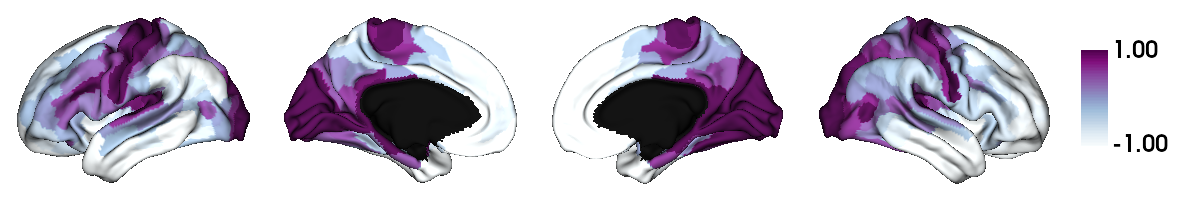

In [11]:
mask = glasser != 0
plot = map_to_labels(mp.mean(axis=0), glasser, mask=mask)
plot[plot==0]=np.nan

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-1,1),
                   cmap = 'BuPu', filename = '../figures/hcp/mean.png')

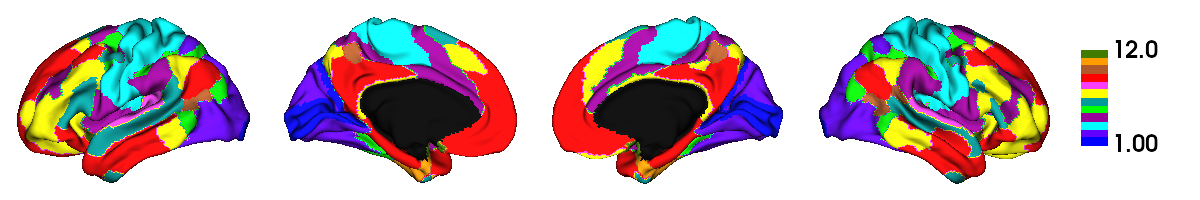

In [12]:
plot = map_to_labels(ca.astype(float), glasser, mask=mask)
plot[plot==0]=np.nan

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(1,12),
                   cmap = cmap, filename = '../figures/hcp/ca_atlas.png')

In [44]:
a = []
for i in range(12):
  a.append(ss.ttest_1samp(ca_asy[:,i],0))
cohen_ca = np.array(a)[:,0]/pow(1101, 0.5)
df = pd.DataFrame(np.vstack((fp.network_name, np.array(a).T, fs.fdr(np.array(a)[:,1]), cohen_ca)).T)
df.columns = ['CA_label', 't', 'p', 'p_fdr','cohen_d']
df.style.set_caption("asymetry VS 0 network-wise")

,CA_label,t,p,p_fdr,cohen_d
0,Vis1,-44.75232155360921,6.021046495701694e-250,9.03156974355254e-250,-1.3487203490237312
1,Vis2,-85.31552661282892,0.0,0.0,-2.571191456348438
2,SMN,26.77972547096763,4.819424239639491e-122,5.783309087567389e-122,0.8070723356931698
3,CON,46.50999946569313,5.415335788506338e-262,9.283432780296581e-262,1.4016922594131698
4,DAN,-72.56157308339877,0.0,0.0,-2.1868199632396474
5,LAN,70.70977773515364,0.0,0.0,2.131011594384104
6,FPN,83.94629470645087,0.0,0.0,2.529926313657406
7,AUD,64.03127723123603,0.0,0.0,1.9297386946126627
8,DMN,3.5443857130166436,0.0004100562632839985,0.0004100562632839985,0.10681870727551124
9,PMN,-62.24717633817621,0.0,0.0,-1.8759704632528946


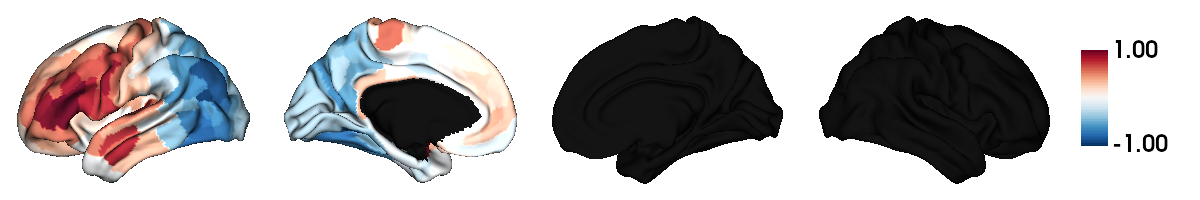

In [14]:
data = asy_total.mean(axis=0)
np.savetxt('../hcp/intensity_asy_mean.txt', data)
plot = map_to_labels(np.concatenate((data,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-1,1),
                   cmap = 'RdBu_r', filename = '../figures/hcp/mean_asy_overall.png')

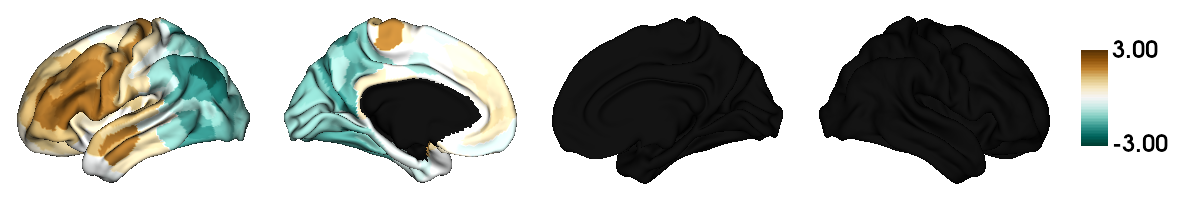

In [15]:
data = cohen.copy()
plot = map_to_labels(np.concatenate((data,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-3,3),
                   cmap = 'BrBG_r', filename = '../figures/hcp/cohen_asy_overall.png')

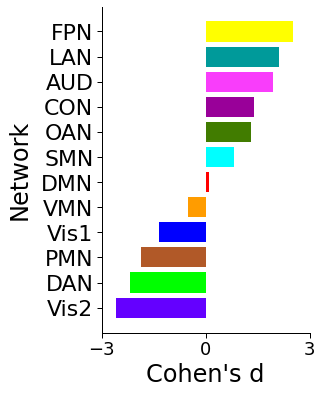

In [45]:
sns.set_context("paper", font_scale = 2.5)
fig, ax = plt.subplots(figsize=(5,6))
fp.plot_t_single_h(cohen_ca, bar=None, ax=ax, thres=3, ascend=True,x_axis=True)
ax.set_ylabel('Network',labelpad=10)
ax.set_xlabel("Cohen's d")
plt.xticks(fontsize=18)
fig.tight_layout()
fig.savefig('../figures/hcp/ca_asy_cohen_bar.png', dpi=300, transparent=True)

In [ ]:
mean = ca_asy.mean(axis=0)
se = []
for i in range(12):
  se.append(fs.se(ca_asy[:,i]))
sns.set_context("paper", font_scale = 2.5)
fig, ax = plt.subplots(figsize=(5,6))
fp.plot_t_single_h(mean, bar=np.array(se), ax=ax, thres=1, ascend=True,x_axis=True)
ax.set_ylabel('Network',labelpad=10)
ax.set_xlabel('AI')
plt.xticks(fontsize=18)
fig.tight_layout()
fig.savefig('../figures/hcp/ca_asy_bar.png', dpi=300, transparent=True)

[(0.4820185328508506, 7.334261738764845e-12), 0.007]

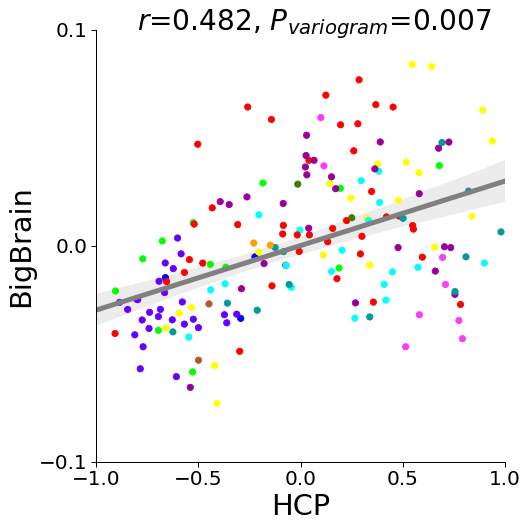

In [17]:
data = asy_total.mean(axis=0).copy()
bb_asy = np.loadtxt('../bigbrain/mp_asy_mean.txt')
target = bb_asy.copy()
rp = fs.spin_pearson(data, target)
color = np.array(list(hcp.ca_network['rgba'].values())[1:])
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(1, figsize=(8,8))
sns.regplot(data, target, ax = ax, 
            scatter_kws={'s': 5, 'color': 'black'},
            line_kws={'lw': 5, 'color': 'grey'})
ax.scatter(data, target,c=ca[:180], cmap=cmap, s=40)
ax.tick_params(axis='both', labelsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(-1, 1)
ax.set_ylim(-0.1, 0.1)
ax.set_yticks([-0.1, 0, 0.1])
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_xlabel('HCP')
ax.set_ylabel('BigBrain')
ax.text(0.1, 1, '$\it{r}$=' + '%.3f'%(rp[0][0])+', $\it{P}$$_{variogram}$='+'%.3f'%(rp[1]), 
        fontsize=28, c='black', transform=ax.transAxes)
fig.tight_layout()
plt.savefig('../figures/hcp/corr_hcp_bb_asy_mean.png', dpi=300, transparent=True)
rp

## Sex age effects

In [18]:
from brainstat.stats.terms import FixedEffect
from brainstat.stats.SLM import SLM
sex = FixedEffect(all_1206['Gender'][mask_sub==1], 'sex')
age = FixedEffect(all_1206['Age'][mask_sub==1], 'age')
sum(sex.sex_F)/1101, age.age.min(), age.age.max()

(0.5440508628519528, 22, 37)

In [19]:
model = sex + age + sex*age
slm_age_sex = SLM(model, contrast=model.matrix['sex_M*age'])
slm_age_sex.fit(asy_total)
t_age_sex = slm_age_sex.t[0]
p_age_sex = np.zeros(180)
dof = model.shape[0] - model.shape[1]
for i in range(180):
  p_age_sex[i] = ss.t.sf(abs(t_age_sex[i]), dof) * 2
if len(np.where(fs.fdr(p_age_sex)<0.05)[0]) == 0:
  print('no age*sex interaction')
  model = sex + age
  slm_sex = SLM(model, contrast=model.sex_M)
  slm_sex.fit(asy_total)
  slm_age = SLM(model, contrast=model.age)
  slm_age.fit(asy_total)
  t_sex = slm_sex.t[0]
  t_age = slm_age.t[0]
  p_sex = np.zeros(180)
  p_age = np.zeros(180)
  dof = model.shape[0] - model.shape[1]
  for i in range(180):
    p_sex[i] = ss.t.sf(abs(t_sex[i]), dof) * 2
    p_age[i] = ss.t.sf(abs(t_age[i]), dof) * 2
else:
  np.where(fs.fdr(p_age_sex)<0.05)[0]

no age*sex interaction


In [20]:
[t_sex.min(), t_sex.max(), t_age.min(), t_age.max(),
 p_sex.min(), p_sex.max(), p_age.min(), p_age.max(),] 

[-11.539788317967025,
 12.223163782671879,
 -3.988472280743321,
 6.086970470934952,
 2.6525448158860743e-32,
 0.9695374884407131,
 1.5884332811393979e-09,
 0.9960388206676192]

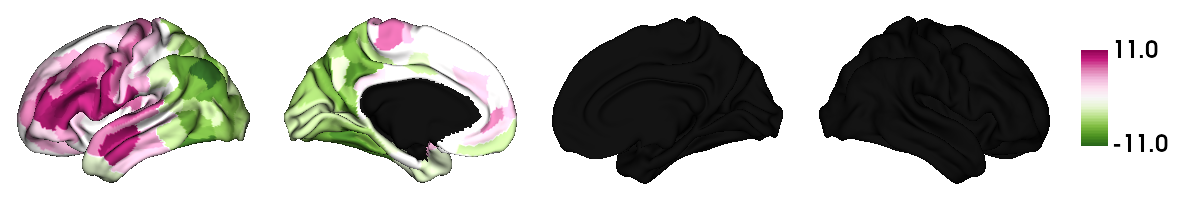

In [21]:
plot = t_sex.copy()
plot[fs.fdr(p_sex)>0.05] = np.inf
plot = map_to_labels(np.concatenate((plot,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan
plot[plot==np.inf] = 0

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-11,11),
                   cmap = 'PiYG_r', filename = '../figures/hcp/asy_tmap_sex.png')

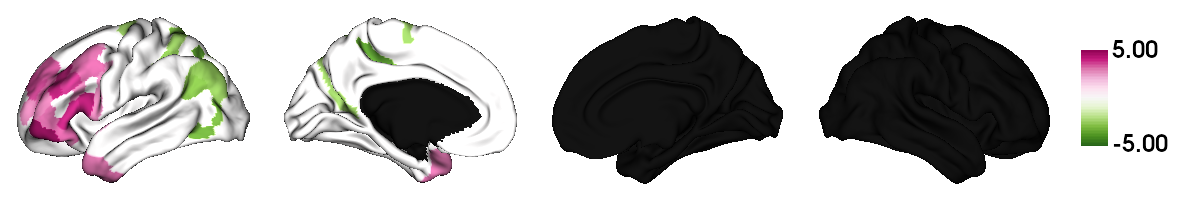

In [22]:
plot = t_age.copy()
plot[fs.fdr(p_age)>0.05] = np.inf
plot = map_to_labels(np.concatenate((plot,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan
plot[plot==np.inf] = 0

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-5,5),
                   cmap = 'PiYG_r', filename = '../figures/hcp/asy_tmap_age.png')

([(0.9611552306265975, 1.893607315452047e-101), 0.0],
 [(0.6899903603058749, 8.886889026983354e-27), 0.0])

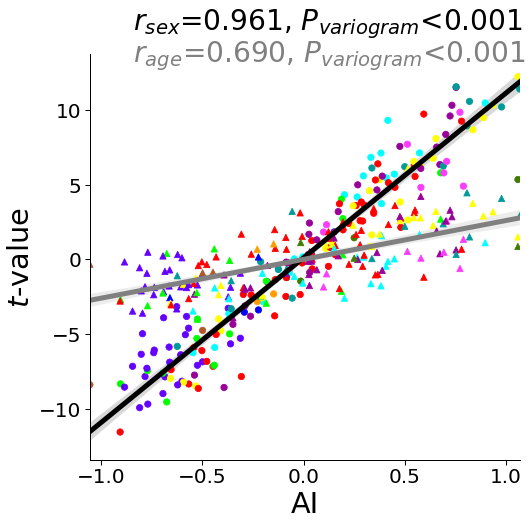

In [23]:
target1=t_sex.copy()
target2=t_age.copy()
rp1 = fs.spin_pearson(data, target1)
rp2 = fs.spin_pearson(data, target2)
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(1, figsize=(8,8))
sns.regplot(data, target1, ax = ax, 
            scatter_kws={'s': 0, 'color': 'red'},
            line_kws={'lw': 5, 'color': 'black'})
sns.regplot(data, target2, ax = ax, 
            scatter_kws={'s': 0, 'color': 'blue'},
            line_kws={'lw': 5, 'color': 'grey'})
ax.scatter(data, target1, c=ca[:180], cmap=cmap, s=40)
ax.scatter(data, target2, c=ca[:180], cmap=cmap, s=40, marker='^')
ax.tick_params(axis='both', labelsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_xlim(-0., 0.6)
#ax.set_ylim(-0.1, 0.1)
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_xlabel('AI')
ax.set_ylabel('$\it{t}$-value')
ax.text(0.1, 1.06, '$\it{r}$$_{sex}$=' + '%.3f'%(rp1[0][0])+', $\it{P}$$_{variogram}$<0.001', 
        fontsize=28, c='black', transform=ax.transAxes)
ax.text(0.1, 0.98, '$\it{r}$$_{age}$=' + '%.3f'%(rp2[0][0])+', $\it{P}$$_{variogram}$<0.001', 
        fontsize=28, c='grey', transform=ax.transAxes)
fig.tight_layout()
plt.savefig('../figures/hcp/corr_tmap_sex_age.png', dpi=300, transparent=True)
rp1, rp2

## Heritability

,index,node,name,H2r,SE,rp
0,0,1,./node_1_INORM,0.352401,0.055840,7.977988e-11
1,2,2,./node_2_INORM,0.513877,0.051210,1.547338e-18
2,1,3,./node_3_INORM,0.291148,0.051800,9.799119e-09
3,6,4,./node_4_INORM,0.267640,0.058681,2.000000e-06
4,3,5,./node_5_INORM,0.432286,0.052793,2.303272e-14
5,11,6,./node_6_INORM,0.225518,0.055237,1.930000e-05
6,9,7,./node_7_INORM,0.390430,0.059360,1.085304e-10
7,7,8,./node_8_INORM,0.304313,0.057655,1.000000e-07
8,5,9,./node_9_INORM,0.277319,0.054739,2.000000e-07
9,8,10,./node_10_INORM,0.337223,0.057040,2.297226e-09


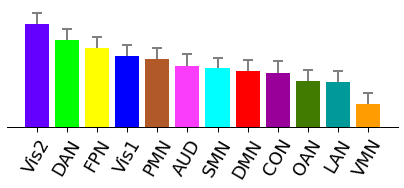

In [24]:
h2_parcel = pd.read_csv('../hcp/solar/intensity_asy_total/1_heri_result.csv').sort_values(by=['node']).reset_index()
h2_ca = pd.read_csv('../hcp/solar/intensity_asy_total_ca/1_heri_result.csv').sort_values(by=['node']).reset_index()

sns.set_context("paper", font_scale = 2)
fig, ax = plt.subplots(figsize=(6,3))
fp.plot_t_single(h2_ca['H2r'], bar=h2_ca['SE'], ax=ax, x_rota=60, thres=0.6, ascend=False)
fig.tight_layout()
fig.savefig('../figures/hcp/inten_asy_h2r.png', dpi=300, transparent=True)
h2_ca

In [43]:
fs.fdr(h2_ca['rp'])

0     3.191195e-10
1     1.856805e-17
2     1.959824e-08
3     2.666667e-06
4     1.381963e-13
5     2.105455e-05
6     3.255913e-10
7     1.714286e-07
8     3.000000e-07
9     5.513342e-09
10    2.268420e-02
11    1.404000e-05
Name: rp, dtype: float64

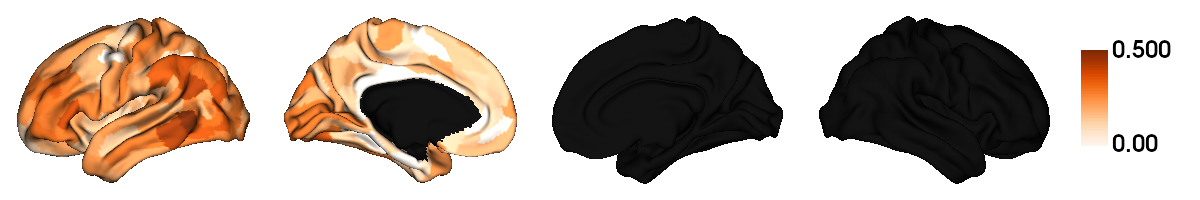

In [25]:
data = np.array(h2_parcel['H2r'])
data[fs.fdr(h2_parcel['rp'])>0.05] = np.inf
plot = map_to_labels(np.concatenate((data,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan
plot[plot==np.inf]=0

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(0,0.5),
                   cmap = 'Oranges', filename = '../figures/hcp/inten_asy_h2r_parcel.png')

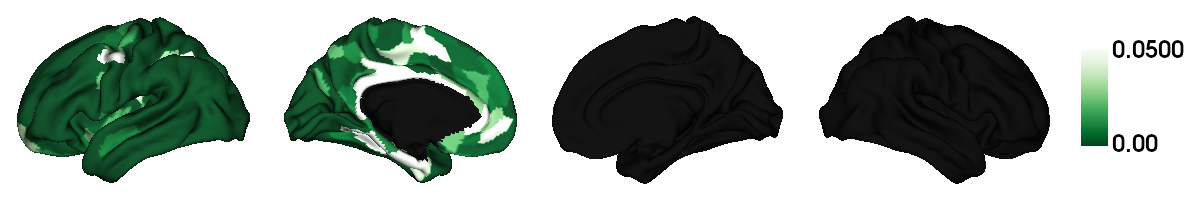

In [26]:
data = fs.fdr(np.array(h2_parcel['rp']))
#data[data>0.05] = 10
plot = map_to_labels(np.concatenate((data,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan
plot[plot==10]=0

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(0,0.05),
                   cmap = 'Greens_r', filename = '../figures/hcp/inten_asy_h2r_fdr_parcel.png')

[(0.4687899529744496, 3.199405195657915e-11), 0.001]

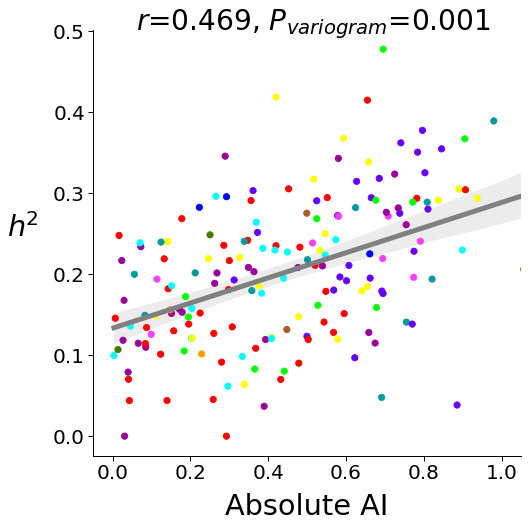

In [27]:
rp = fs.spin_pearson(np.array(h2_parcel['H2r']), abs(asy_total.mean(axis=0)))
color = np.array(list(hcp.ca_network['rgba'].values())[1:])
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(1, figsize=(8,8))
sns.regplot(abs(asy_total.mean(axis=0)), h2_parcel['H2r'], ax = ax, 
            scatter_kws={'s': 5, 'color': 'black'},
            line_kws={'lw': 5, 'color': 'grey'})
ax.scatter(abs(asy_total.mean(axis=0)), h2_parcel['H2r'],c=ca[:180], cmap=cmap, s=40)
ax.tick_params(axis='both', labelsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(-0.05, 1.05)
ax.set_xlabel('Absolute AI', labelpad=10)
ax.set_ylabel('$\it{h}$$^2$', labelpad=30, rotation=0)
ax.text(0.1, 1, '$\it{r}$=' + '%.3f'%(rp[0][0])+', $\it{P}$$_{variogram}$='+'%.3f'%(rp[1]), 
        fontsize=28, c='black', transform=ax.transAxes)
fig.tight_layout()
plt.savefig('../figures/hcp/corr_intenAsy_h2r.png', dpi=300, transparent=True)
rp

# structure-Function

## Group level

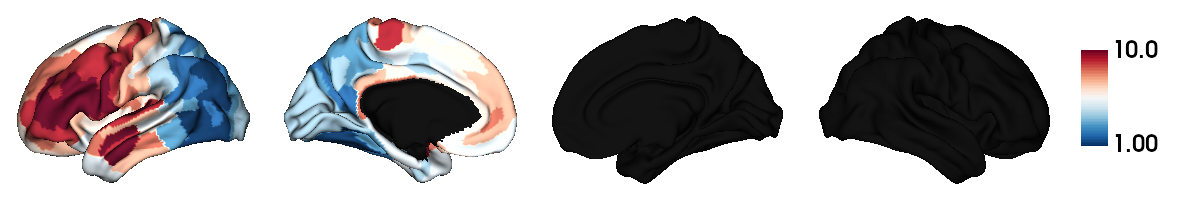

In [28]:
data = asy_total.mean(axis=0)
bin=10
plot = ss.rankdata(data)-1
for i in range(bin):
  plot[np.logical_and(plot>=i*int(180/bin), plot < i*int(180/bin)+int(180/bin))] = i+1
plot_bin=plot.copy()
plot = map_to_labels(np.concatenate((plot_bin,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(1,bin),
                   cmap = 'RdBu_r', filename = '../figures/hcp/mean_asy_overall_bin.png')

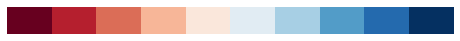

In [29]:
gradient = np.linspace(0, 1, 10)
gradient = np.vstack((gradient, gradient))
fig = plt.figure(figsize=(8,0.5))
ax = fig.add_subplot(111)
ax.imshow(gradient, aspect='auto', cmap='RdBu')
ax.set_axis_off()
fig.tight_layout()
fig.savefig('../figures/colorbar/RdBu_10bin.png', dpi=300, transparent=True)  

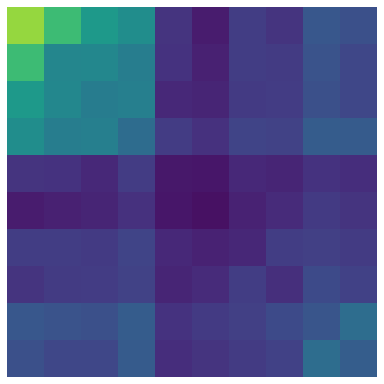

In [30]:
fc_LL = np.loadtxt('../hcp/func/FC/LL_groupmean.csv',delimiter=',')
fc_LL_rank = fc_LL[data.argsort()][:,data.argsort()]
bin=10
fc_LL_bin = np.zeros((bin,bin))
for i in range(bin):
    for j in range(bin):
       fc_LL_bin[i,j] = fc_LL_rank[i*int(180/bin):i*int(180/bin)+int(180/bin), j*int(180/bin):j*int(180/bin)+int(180/bin)].mean(axis=None)

fig, ax = plt.subplots(1, figsize=(6,6))
ax.imshow(fc_LL_bin, cmap='viridis', vmax=0.4, vmin=0.1)
ax.set_axis_off()
fig.tight_layout()
plt.savefig('../figures/hcp/fc_LL_rankedbyai.png', dpi=300, transparent=True)

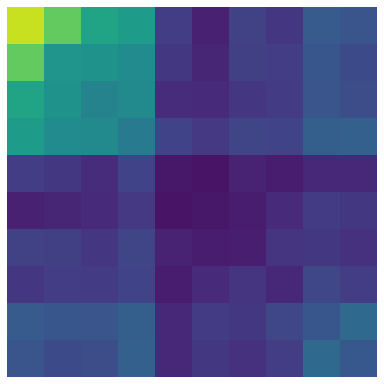

In [31]:
fc_RR = np.loadtxt('../hcp/func/FC/RR_groupmean.csv',delimiter=',')
fc_RR_rank = fc_RR[data.argsort()][:,data.argsort()]
bin=10
fc_RR_bin = np.zeros((bin,bin))
for i in range(bin):
    for j in range(bin):
       fc_RR_bin[i,j] = fc_RR_rank[i*int(180/bin):i*int(180/bin)+int(180/bin), j*int(180/bin):j*int(180/bin)+int(180/bin)].mean(axis=None)

fig, ax = plt.subplots(1, figsize=(6,6))
ax.imshow(fc_RR_bin, cmap='viridis', vmax=0.4, vmin=0.1)
ax.set_axis_off()
fig.tight_layout()
plt.savefig('../figures/hcp/fc_RR_rankedbyai.png', dpi=300, transparent=True)

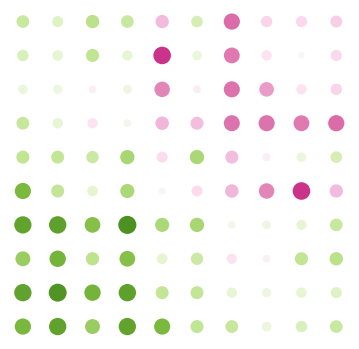

In [32]:
fc_asy_bins = (fc_LL_bin - fc_RR_bin)/(fc_LL_bin + fc_RR_bin)
df=pd.DataFrame()
matrix = np.arange(0, 100).reshape((10, 10)) % 10
df['x'] = matrix.flatten()
df['y'] = matrix.T.flatten()
df['color'] = fc_asy_bins.flatten()
df['size'] = abs(fc_asy_bins).flatten()
sns.relplot(data=df, x='x', y='y',hue='color', size='size', palette="PiYG_r",
            sizes=(40, 400), linewidth=0, legend=False,
            hue_norm=(-0.05, 0.05), size_norm=(0, 0.05),
            aspect=1, height=6)
plt.axis('off')
#plt.tight_layout()
plt.savefig('../figures/hcp/fc_intra_rankedbyai.png', dpi=300, transparent=True)

## Individual coupling

In [33]:
import os
sub = os.listdir('../hcp/func/FC/LL/')
sub.sort()
sub_list=[]
sub_func_LL=[]
sub_func_RR=[]
for i in sub:
    sub_list.append(int(i[:6]))
    sub_func_LL.append(np.loadtxt('../hcp/func/FC/LL/'+i, delimiter=','))
    sub_func_RR.append(np.loadtxt('../hcp/func/FC/RR/'+i, delimiter=','))
mask_func = np.zeros(1206)
for i in range(1206):
  if all_1206.ID[i] in sub_list:
      mask_func[i] = 1
#mask_func_struc = np.logical_and(mask_sub==1, mask_func==1)

In [34]:
indi_func_ll = np.array(sub_func_LL)[mask_sub[mask_func==1] == 1]
indi_func_rr = np.array(sub_func_RR)[mask_sub[mask_func==1] == 1]

indi_asy_func = indi_func_ll - indi_func_rr
indi_asy_struc = asy_total[mask_func[mask_sub==1] == 1]
indi_corr = np.zeros((180,180)) # struc, func
for i in range(180):
  for j in range(180):
    indi_corr[i,j] = ss.pearsonr(indi_asy_struc[:,i], indi_asy_func[:,i,j])[0]

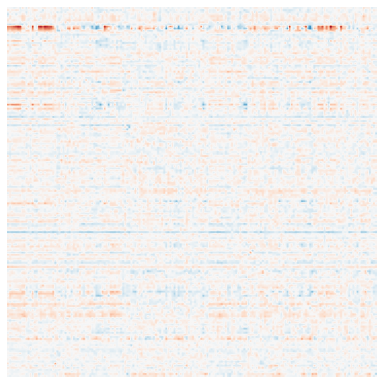

In [35]:
#indi_corr_z = np.arctanh(indi_corr)
indi_corr[np.isnan(indi_corr)] = 0
#rank = indi_corr_z.mean(axis=1).argsort()
fig, ax = plt.subplots(1, figsize=(6,6))
ax.imshow(indi_corr, cmap='RdBu_r', vmax=0.5, vmin=-0.5)
ax.set_axis_off()
fig.tight_layout()
plt.savefig('../figures/hcp/corr_struc_func_acrosssubjecs.png', dpi=300, transparent=True)

In [36]:
indi_corr.min(), indi_corr.max(),indi_corr.shape

(-0.32614278770718985, 0.4405917499460549, (180, 180))

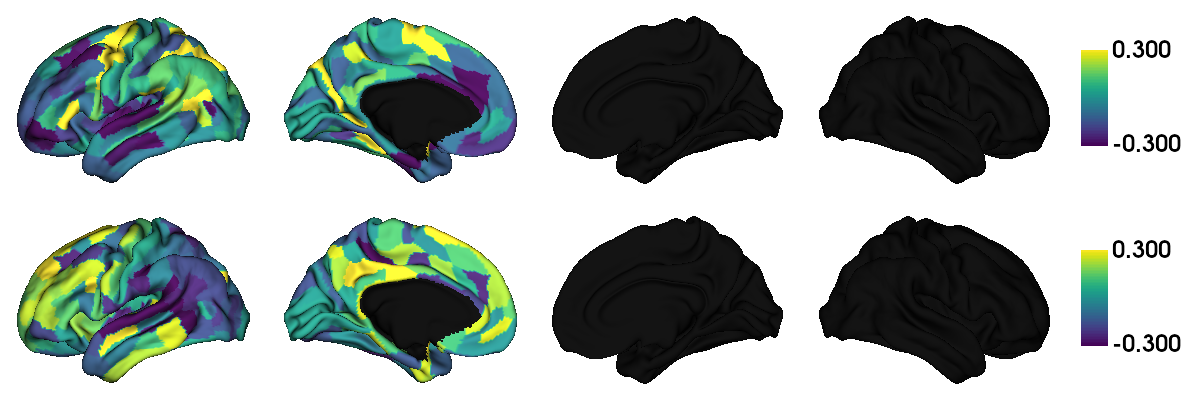

In [46]:
gm = GradientMaps(n_components=10, random_state=0, approach='pca', kernel='normalized_angle')
gm.fit(indi_corr)

plot=[None]*2
for i in range(2): 
    plot[i] = map_to_labels(np.concatenate((gm.gradients_[:,i],np.zeros(180))), glasser, mask=mask)
    plot[i][plot[i]==0]=np.nan

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 400), color_range=(-0.3, 0.3),
                   cmap = 'viridis', filename = '../figures/hcp/hcp_struc_func_asy_covariance_row.png')

[0.26626013 0.17408371 0.16500044 0.08397745 0.07810886 0.05808062
 0.04977039 0.04351357 0.04123489 0.03996994]


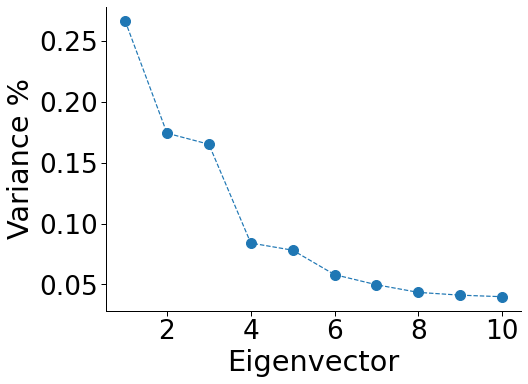

In [47]:
sns.set_context("paper", font_scale = 3)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(range(1,11), gm.lambdas_/np.sum(gm.lambdas_),'o', ms=10, ls='--')
#plt.plot(range(1,11), variance_ll/np.sum(variance_ll),c='darkblue')
plt.xlabel('Eigenvector')
plt.ylabel('Variance %')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('../figures/hcp/hcp_struc_func_asy_covariance_row_explain.png', dpi=300, transparent=True)
print(gm.lambdas_/np.sum(gm.lambdas_))

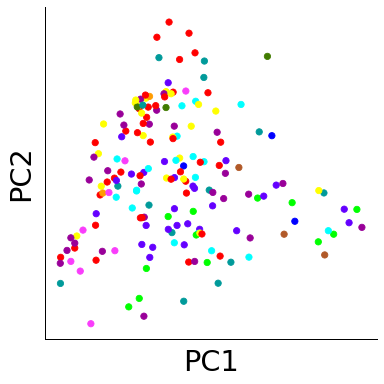

In [48]:
sns.set_context("paper", font_scale = 3)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(gm.gradients_[:,0], gm.gradients_[:,1], s = 40,  c = ca[:180], cmap=cmap, marker = 'o')
ax.set_xlabel('PC1',labelpad=10)
ax.set_ylabel('PC2',labelpad=10)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()
fig.savefig('../figures/hcp/hcp_struc_func_asy_covariance_row_2d.png', dpi=300, transparent=True)

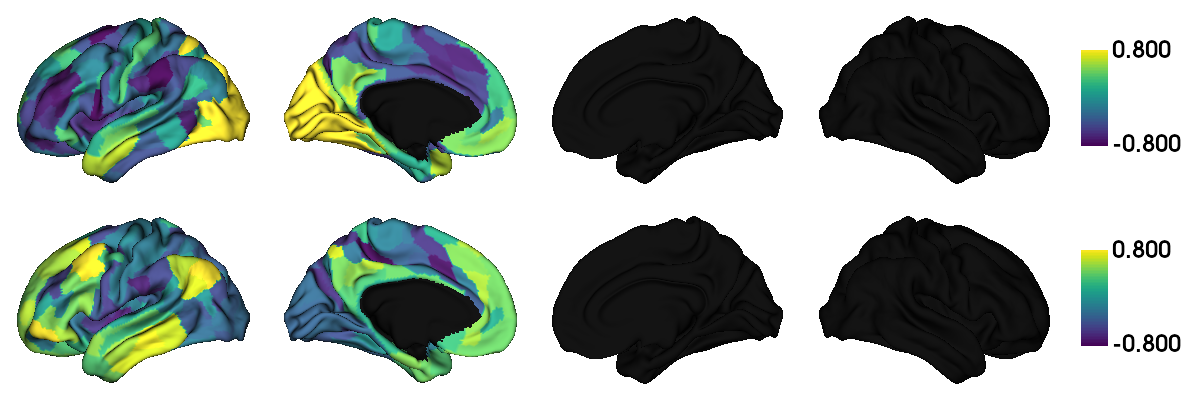

In [40]:
gm = GradientMaps(n_components=10, random_state=0, approach='pca', kernel='normalized_angle')
gm.fit(indi_corr.T)

plot=[None]*2
for i in range(2): 
    plot[i] = map_to_labels(np.concatenate((gm.gradients_[:,i],np.zeros(180))), glasser, mask=mask)
    plot[i][plot[i]==0]=np.nan

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 400), color_range=(-0.8,0.8),
                   cmap = 'viridis', filename = '../figures/hcp/hcp_struc_func_asy_covariance_col.png')

[0.48416925 0.25810574 0.10448544 0.03954452 0.03382833 0.02675395
 0.01693448 0.01571177 0.01048667 0.00997986]


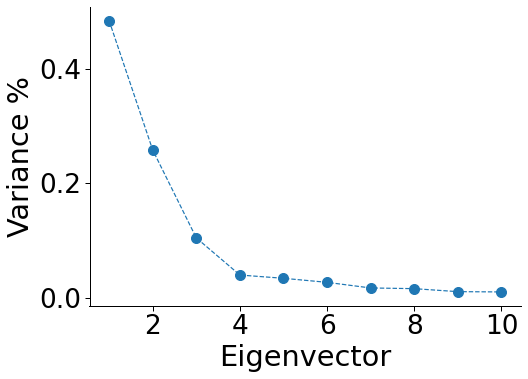

In [41]:
sns.set_context("paper", font_scale = 3)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(range(1,11), gm.lambdas_/np.sum(gm.lambdas_),'o', ms=10, ls='--')
#plt.plot(range(1,11), variance_ll/np.sum(variance_ll),c='darkblue')
plt.xlabel('Eigenvector')
plt.ylabel('Variance %')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('../figures/hcp/hcp_struc_func_asy_covariance_col_explain.png', dpi=300, transparent=True)
print(gm.lambdas_/np.sum(gm.lambdas_))

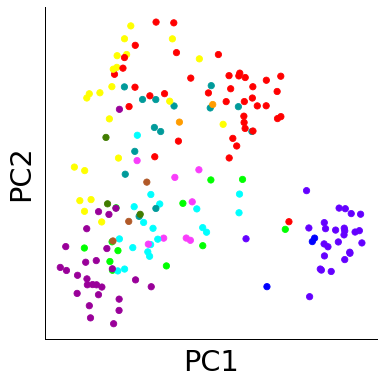

In [42]:
sns.set_context("paper", font_scale = 3)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(gm.gradients_[:,0], gm.gradients_[:,1], s = 40, c = ca[:180], cmap=cmap, marker = 'o')
ax.set_xlabel('PC1',labelpad=10)
ax.set_ylabel('PC2',labelpad=10)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()
fig.savefig('../figures/hcp/hcp_struc_func_asy_covariance_col_2d.png', dpi=300, transparent=True)